## Synthetic Voice Deepfakes Detection Using MFCC Features

#### 1. Intro
This notebook walks through the process of creating labeled audio data, extracting features, and training a machine learning model to distinguish between real and fake voices using MFCCs (Mel-frequency cepstral coefficients). The goal is to build a system that can accurately identify synthetic voices and provide real-time alerts.

#### 2. Setup

In [3]:
import sys
sys.path.append('..')
from paths import CODE_DIR

In [4]:
import os
import librosa, numpy as np, scipy, matplotlib, sklearn, pandas as pd
from gtts import gTTS
from pydub import AudioSegment


#### 3. Data Preparation
We define the paths for the audio files and the transcript data, then load the transcript CSV for further processing.

In [28]:
transcripts_path = os.path.join(CODE_DIR, 'assets', 'audio', 'transcripts', 'transcripts.csv')

original_audio_path = os.path.join(CODE_DIR, 'assets', 'audio', 'original_audio')
generated_audio_path = os.path.join(os.getcwd(), 'generated_audio','fake')
os.makedirs(generated_audio_path, exist_ok=True)


transcripts = pd.read_csv(transcripts_path)

#### 4. Generate Fake Audio Samples
Generate synthetic voices using the Google Text-to-Speech (gTTS) library based on the transcript data and save them as .wav files.

In [29]:
existing_files = [f for f in os.listdir(generated_audio_path) if f.endswith(('.wav', '.mp3'))]
if len(existing_files) == 0:
    print("No fake audio files found. Generating them now...")
    for index, row in transcripts.iterrows():
        text = row['text']
        id = row['id'].replace('.mp3', '')
        tts = gTTS(text=text, lang='en')
        filename = f"{id}.wav"
        tts.save(os.path.join(generated_audio_path, filename))
    print(f'{len(transcripts)} audio files saved in {generated_audio_path}')
else:
    print(f"Found {len(existing_files)} existing fake audio files in {generated_audio_path}")

Found 57 existing fake audio files in /Users/giovannipoveda/Documents/deepfake_voice_clonning/code/notebooks/generated_audio/fake


#### 5. Labeling Audio Data

In [34]:
data = []

for fname in os.listdir(original_audio_path):
        data.append({"file": os.path.join(original_audio_path, fname), "label": "real"})

for fname in os.listdir(generated_audio_path):
    if fname.endswith('.wav'):
        data.append({"file": os.path.join(generated_audio_path, fname), "label": "fake"})

labeled_data = pd.DataFrame(data)

#### 6. Feature Extraction (MFCC)
We extract Mel-frequency cepstral coefficients (MFCC) from the audio files as features to train the model.

**Definition**: MFCCs represent the short-term power spectrum of a sound, based on a linear cosine transform of a log power spectrum on a nonlinear mel scale of frequency. They aim to mimic the way humans perceive sound, especially how we’re more sensitive to certain frequency ranges (like speech).

In [35]:
def extract_mfcc(path, n_mfcc=13):
    y, sr = librosa.load(path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    return mfcc_mean

labeled_data["features"] = labeled_data["file"].apply(extract_mfcc)


In [36]:
labeled_data[labeled_data['label'] == 'real'].tail()

,file,label,features
55,/Users/giovannipoveda/Documents/deepfake_voice...,real,"[-427.33246, 63.240486, -12.268024, 17.977423,..."
56,/Users/giovannipoveda/Documents/deepfake_voice...,real,"[-426.04346, 87.81051, -4.70074, 11.842736, 13..."
57,/Users/giovannipoveda/Documents/deepfake_voice...,real,"[-396.7584, 104.18587, -11.018372, 10.071069, ..."
58,/Users/giovannipoveda/Documents/deepfake_voice...,real,"[-404.06424, 114.20602, -6.119465, 11.63023, 9..."
59,/Users/giovannipoveda/Documents/deepfake_voice...,real,"[-415.3354, 92.91116, -24.26887, 15.380234, -0..."


#### 7. Train-Test Split

In [37]:
from sklearn.model_selection import train_test_split

X = np.stack(labeled_data["features"].values)
y = labeled_data["label"].map({"real": 0, "fake": 1}).values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


#### 8. Model Training

In [38]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

#### 9. Model Evaluation

In [39]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



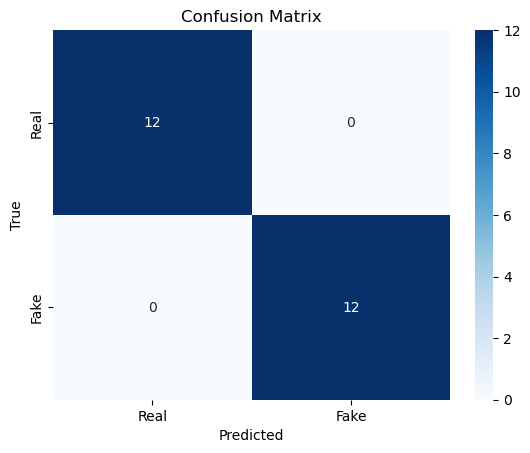

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

#### 11. PCA for Feature Visualization
Principal Component Analysis (PCA) is used to reduce the feature dimensions and visualize the data in 2D space.

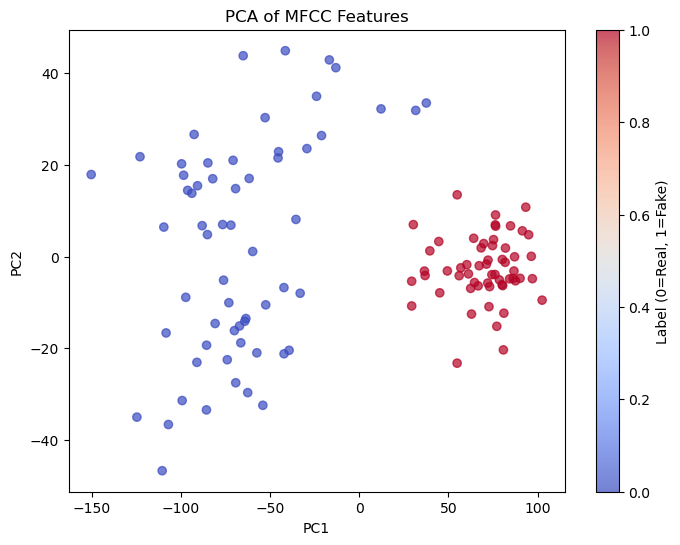

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.7)
plt.title("PCA of MFCC Features")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Label (0=Real, 1=Fake)')
plt.show()


#### 12. Audio Duration Analysis
We analyze the duration of the audio files to check for any significant differences between real and fake voices.

In [42]:
def get_duration(path):
    y, sr = librosa.load(path, sr=None)
    return librosa.get_duration(y=y, sr=sr)

labeled_data["duration"] = labeled_data["file"].apply(get_duration)
labeled_data.groupby("label")["duration"].describe()


,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
fake,57.0,4.784842,1.421572,2.328,3.888,4.872,5.448,10.896
real,60.0,6.698400,2.002080,3.204,5.382,6.120,8.289,11.520


#### 13. Model Retraining or Tuning

In [43]:
# Example of re-training or model tuning code (optional section for experimentation)
clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(n_estimators=200, random_state=42)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00        12

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24



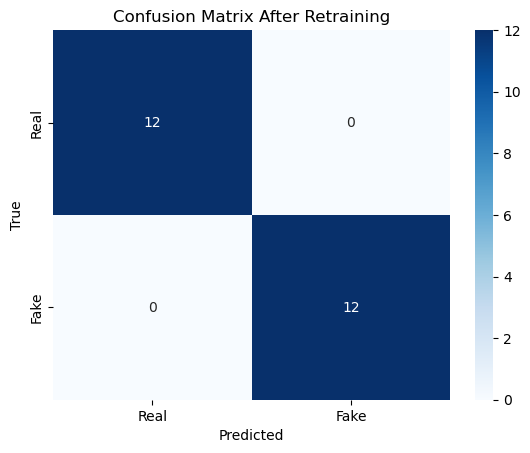

In [44]:
# Re-evaluating the model after retraining
y_pred_retrained = clf.predict(X_test)

# Printing the classification report
print(classification_report(y_test, y_pred_retrained))

# Visualizing the confusion matrix for the retrained model
cm_retrained = confusion_matrix(y_test, y_pred_retrained)

sns.heatmap(cm_retrained, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix After Retraining")
plt.show()